In [3]:
## Imports
%load_ext autoreload
%autoreload 2
import tensorflow as tf
from tensorflow import keras
from MachineLearning.dataset import get_dataset
import time
import numpy as np

loaded packages


In [6]:
### Here we define our own modified UNet: (link paper)

from keras import Sequential, Model, activations, regularizers

from keras.layers import Input, Dense, BatchNormalization, Dropout, Conv2D, UpSampling2D, MaxPooling2D, concatenate, LeakyReLU, ReLU, Softmax, ZeroPadding2D, Cropping2D, Flatten, Reshape

def upsample_block(filters, up_sample_size, kernel_size, dropout=False):

    ## Upsample using nearest neighbors -> conv2d -> batchnorm -> dropout -> Relu

    result = Sequential()

    result.add(UpSampling2D(size = up_sample_size, interpolation="nearest"))
    result.add(Conv2D(filters = filters, kernel_size=kernel_size, padding='same', kernel_regularizer='l2', kernel_initializer='HeNormal'))

    #result.add(BatchNormalization())

    if dropout:
        result.add(Dropout(0.5))
    
    result.add(Conv2D(filters = filters, kernel_size=kernel_size, padding='same', kernel_regularizer='l2', kernel_initializer='HeNormal', use_bias=False))
   
    #result.add(BatchNormalization())

    result.add(ReLU())

    return result

def downsample_block(filters, size, dropout=False):

    # Downsample using conv2d -> Batchnorm -> Max Pool -> leakyReLU

    result = Sequential()
    result.add(
        Conv2D(filters, size, padding='same', kernel_initializer='HeNormal', kernel_regularizer='l2', activation=LeakyReLU()))

    #result.add(BatchNormalization())

    if dropout:
        result.add(Dropout(0.5))

    result.add(
        Conv2D(filters, size, padding='same', kernel_initializer='HeNormal', kernel_regularizer='l2', activation=LeakyReLU()))
    
    #result.add(BatchNormalization())

    result.add(MaxPooling2D((2,2), padding='same'))

    return result

def bottleneck():
    result = Sequential()

    result.add(Dense(256, activation=LeakyReLU()))

    return result

def UNet(genesis_size, movement_size, output_channels = 1):

    genesis = Input(shape=genesis_size)
    #movement = Input(shape=movement_size)
    skips = []

    x = Conv2D(64, (3,3), activation=LeakyReLU(), padding='same', kernel_regularizer='l2', kernel_initializer='HeNormal')(genesis)

    down_filters = [64, 128, 256]
    for i, filters in enumerate(down_filters):

        skips.append(x)
        x = downsample_block(filters, (3,3))(x)

    x = bottleneck()(x)
    
    ## outputs are twice as big as inputs
    up_filters = [256, 128, 64, 32]
    for i, filters in enumerate(up_filters):

        x = upsample_block(filters, (2,2), (3,3))(x)

        if i < len(down_filters):
            skip = skips[len(down_filters) - i - 1]
            b, h, w, c = skip.shape
            b, h1, w1, c = x.shape
            diffY = h1 - h
            diffX = w1 - w

            #padded_skip = ZeroPadding2D(padding=()(skip)
            
            cropped_x = Cropping2D(cropping=((diffY // 2, diffY - diffY//2), (diffX // 2, diffX - diffX // 2)))(x)

            x = concatenate([cropped_x,skip])
            
    
    output = Conv2D(output_channels, (1,1), kernel_initializer='HeNormal', kernel_regularizer='l2', activation=tf.keras.activations.elu)(x)
    
    model = Model(inputs=[genesis], outputs=[output])

    return model


create dataset time: 0.041133880615234375
create dataset time: 0.036348819732666016
create dataset time: 0.03562641143798828
../storm_data/v3/AllData_1713492501.118955.hdf5


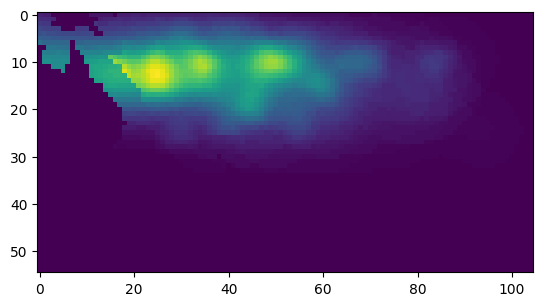

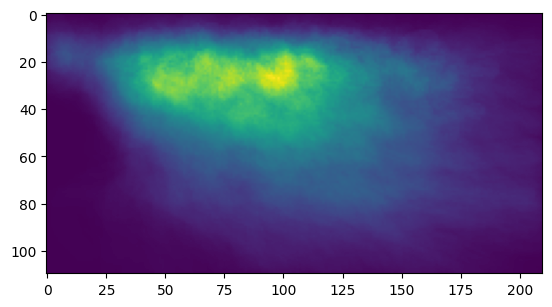

Epoch 1/40

Epoch 1: saving model to models/unet_mean_1713498584.2015321.keras
1/1 - 4s - loss: 44.7391 - mean_squared_error: 6.4019 - mean_absolute_error: 1.9256 - 4s/epoch - 4s/step
Epoch 2/40

Epoch 2: saving model to models/unet_mean_1713498584.2015321.keras
1/1 - 1s - loss: 41.7468 - mean_squared_error: 3.4123 - mean_absolute_error: 1.3958 - 704ms/epoch - 704ms/step
Epoch 3/40

Epoch 3: saving model to models/unet_mean_1713498584.2015321.keras
1/1 - 1s - loss: 42.0627 - mean_squared_error: 3.7311 - mean_absolute_error: 1.5880 - 691ms/epoch - 691ms/step
Epoch 4/40

Epoch 4: saving model to models/unet_mean_1713498584.2015321.keras
1/1 - 1s - loss: 39.8745 - mean_squared_error: 1.5457 - mean_absolute_error: 0.9953 - 702ms/epoch - 702ms/step
Epoch 5/40

Epoch 5: saving model to models/unet_mean_1713498584.2015321.keras
1/1 - 1s - loss: 40.5056 - mean_squared_error: 2.1800 - mean_absolute_error: 1.2127 - 699ms/epoch - 699ms/step
Epoch 6/40

Epoch 6: saving model to models/unet_mean_17

In [9]:

genesis_size_default = (55, 105, 1)
movement_size_default = (11, 13)
output_size_default = (110, 210, 1)

import matplotlib.pyplot as plt

def train_unet(data_folder, epochs=50, genesis_size=genesis_size_default, movement_size=movement_size_default, output_size=1):
    train_data = get_dataset(data_folder, data_version=3, batch_size=1)
    test_data = get_dataset(data_folder, dataset="test", data_version=3)
    
    validation_data = get_dataset(data_folder, dataset="validation", data_version=3)
    
    one_train_sample = next(iter(train_data))
    inp, out = one_train_sample
    plt.imshow(inp[0])
    plt.show()
    plt.imshow(out[0])
    plt.show()

    model = UNet(genesis_size, movement_size, output_size)

    early_stopping = keras.callbacks.EarlyStopping()
    checkpoint = keras.callbacks.ModelCheckpoint('models/unet_mean_{}.keras'.format(str(time.time())), save_best_only=False, save_weights_only=True, mode='min',
                                                 verbose=1)

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.00003),
        loss=keras.losses.MeanSquaredError(reduction="sum_over_batch_size", name="mean_squared_error"),
        metrics=[keras.metrics.MeanSquaredError(), keras.metrics.MeanAbsoluteError()]
    )

    model.fit(
        inp,
        out,
        epochs=40,
        verbose=2,
        callbacks=[checkpoint]
    )

    #model.evaluate(
        #x=test_data,
    #)


keras.backend.clear_session()
train_unet('../storm_data/v3/')


In [1]:
## Test predictions
import tensorflow as tf
from tensorflow import keras
from MachineLearning.dataset import get_dataset
from MachineLearning.UNet.unet import UNet
import numpy as np
import os

genesis_size = (55, 105, 1)
movement_size = (11, 13)

def predictions(model_path, data_folder):
    
    model = UNet(genesis_size, movement_size, 1)
    model.load_weights(model_path)
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-5),
        loss=keras.losses.MeanSquaredError(reduction="sum_over_batch_size", name="mean_squared_error")
    )
    train_data = get_dataset(data_folder, data_version=3, dataset='test', batch_size=1)
    
    one_train_sample = next(iter(train_data))
    inp, out = one_train_sample
    
    predictions = model.predict(
            inp,
            batch_size=1,
            verbose=2,
            steps=1
        )
    return out, predictions
#model_path = 'models/unet_mean_1713491606.6254027.keras'
#model_path = 'models/unet_mean_1713493671.5580592.keras'
#model_path = 'models/unet_mean_1713749420.165303.keras'

## 'models/unet_mean_1713754646.2664263.keras'
## Use this as a UNET Baseline??
## Trained with no reg., 0.0003 learning rate for 40 epochs with early stopping.
## Show what the site specific loss was and the maps
## Then say that it is struggling to learn the full variation because model capacity isn't high enough (hence why regularization wasn't needed).
## Compare with network that used 0's as inputs (the one trained immediately before this one)

model_path = 'models/unet_mean_1713754646.2664263.keras'
data_folder = '/nesi/project/uoa03669/ewin313/storm_data/v3/'
outputs, predictions = predictions(model_path, data_folder)


2024-04-23 09:03:39.087881: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


loaded packages


2024-04-23 09:04:36.726721: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error


create dataset time: 0.03453516960144043
/nesi/project/uoa03669/ewin313/storm_data/v3/AllData_1713492501.118955.hdf5
/nesi/project/uoa03669/ewin313/storm_data/v3/AllData_1713326775.7941182.hdf5
/nesi/project/uoa03669/ewin313/storm_data/v3/AllData_1713326816.459453.hdf5
/nesi/project/uoa03669/ewin313/storm_data/v3/AllData_1713492472.9932106.hdf5
/nesi/project/uoa03669/ewin313/storm_data/v3/AllData_1713492473.2374349.hdf5
/nesi/project/uoa03669/ewin313/storm_data/v3/AllData_1713326784.5527074.hdf5
/nesi/project/uoa03669/ewin313/storm_data/v3/AllData_1713492472.9653578.hdf5
/nesi/project/uoa03669/ewin313/storm_data/v3/AllData_1713492472.9191742.hdf5
/nesi/project/uoa03669/ewin313/storm_data/v3/AllData_1713492473.014685.hdf5
/nesi/project/uoa03669/ewin313/storm_data/v3/AllData_1713326816.7361786.hdf5
/nesi/project/uoa03669/ewin313/storm_data/v3/AllData_1713492501.1442902.hdf5
/nesi/project/uoa03669/ewin313/storm_data/v3/AllData_1713303493.6639426.hdf5
/nesi/project/uoa03669/ewin313/storm_d

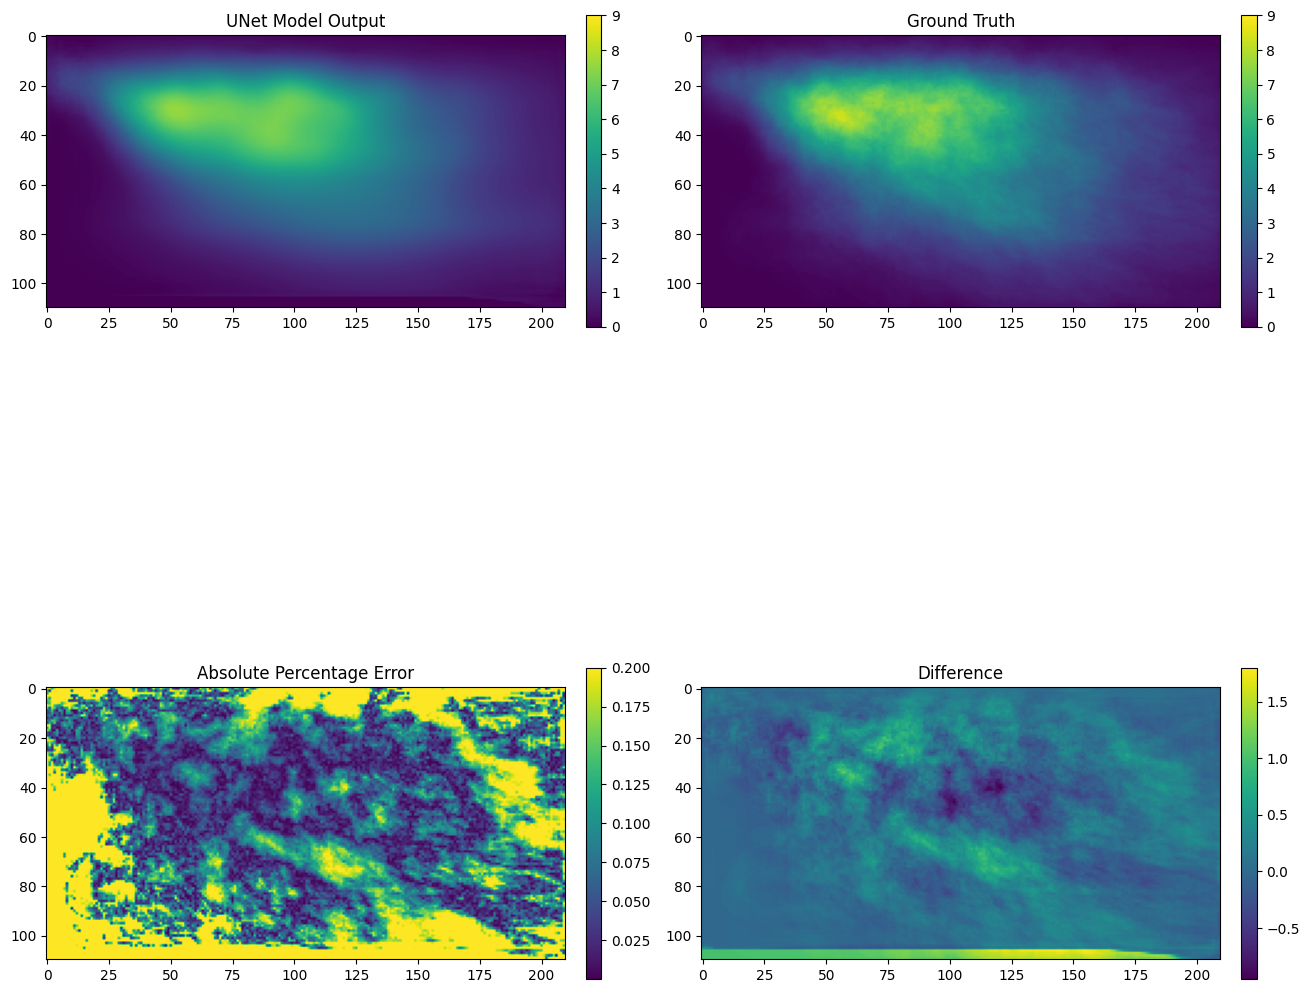

1.1663388 -649.98254


In [32]:
import matplotlib.pyplot as plt
#from HealthFacilities.getHealthFacilityData import *
import pandas as pd
#sites = Sites(5)
### Define metrics to evaluate the model
import math

def getGridCell(lat, lon, resolution, basin):
    '''
    Get the grid cell for given latitude, longitude, and grid resolution

    :return: indices of the lat and lon cells respectively
    '''

    lat0, lat1, lon0, lon1 = -60, -5, 135, 240

    if lat < lat0 or lat >= lat1:
        raise "lat must be within the basin"

    if lon < lon0 or lon >= lon1:
        raise "lon must be within the basin"

    latCell = math.floor((lat - lat0) * 1/resolution)
    lonCell = math.floor((lon - lon0) * 1/resolution)

    return latCell, lonCell

def getHealthFacilityData():
        """
        :param file_paths:
        :return:
        """
        #__location__ = os.path.realpath(os.path.join(os.getcwd(), os.path.dirname(__file__)))

        files = ['SPC_health_data_hub_Kiribati.csv', 'SPC_health_data_hub_Solomon_Islands.csv', 'SPC_health_data_hub_Tonga.csv', 'SPC_health_data_hub_Vanuatu.csv']
        file_paths = [os.path.join('./HealthFacilities', file) for file in files]
        locations = []

        for file_path in file_paths:
            df = pd.read_csv(file_path)

            latitudes = df.loc[:, "LATITUDE: Latitude"]
            longitudes = df.loc[:, "LONGITUDE: Longitude"]


            ## adjust because our longitudes go from 0 to 360 not -180 to 180
            for i in range(len(longitudes)):
                if latitudes.loc[i] > -5 or latitudes.loc[i] < -60: continue# not in basin

                if longitudes.loc[i] < 0:
                    df.loc[i, "LONGITUDE: Longitude"] += 360

                locations.append((latitudes.loc[i], longitudes.loc[i]))

        return locations

sites = getHealthFacilityData()
    
def site_error(pred, true, sites):
    
    squared_errors = []
    percentage_errors = []
    
    for site in sites:
        
        cell = getGridCell(*site, .5, 'SP')
        squared_error = (pred[cell] - true[cell])**2
        percentage_error = (pred[cell] - true[cell])/(true[cell])**2
        
    
        squared_errors.append(squared_error)
        percentage_errors.append(percentage_error)

    return squared_errors, percentage_errors


for i in range(len(predictions)):
    
    fig, axs = plt.subplots(2, 2, layout='constrained', figsize=(13,13))
    ims = axs[0, 0].imshow(predictions[i])
    ims.set_clim(0, 9)
    axs[0,0].set_title('UNet Model Output')
    plt.colorbar(ims, ax=axs[0,0], fraction=0.03, pad=0.04)
    ims = axs[0, 1].imshow(outputs[i])
    ims.set_clim(0, 9)
    
    plt.colorbar(ims, ax=axs[0,1], fraction=0.03, pad=0.04)
    axs[0,1].set_title('Ground Truth')

    ims = axs[1, 0].imshow(np.abs(np.clip((outputs[i] - predictions[i])/(outputs[i]), a_min=-.2, a_max=.2)))
    axs[1,0].set_title('Absolute Percentage Error')
    plt.colorbar(ims, ax=axs[1,0], fraction=0.03, pad=0.04)
    ims = axs[1, 1].imshow(outputs[i] - predictions[i])
    axs[1,1].set_title('Difference')
    plt.colorbar(ims, ax=axs[1,1], fraction=0.03, pad=0.04)
    plt.show()
    '''print(np.max(outputs[i]))
    plt.imshow(predictions[i])
    plt.colorbar()
    plt.show()
    plt.imshow(outputs[i])
    plt.colorbar()
    plt.show()
    
    plt.imshow(np.abs(np.clip((outputs[i] - predictions[i])/(outputs[i]), a_min=-.2, a_max=.2)))
    plt.colorbar()
    plt.show()
    '''
    squared_errors, percentage_errors = site_error(predictions[i], outputs[i], sites)
    print(np.max(squared_errors), np.min(percentage_errors))
    

In [31]:

def get_weight_grad(model, data, labels):
  
    means = []
    stds = []

    grads = model.optimizer.get_gradients(model.total_loss, model.trainable_weights)
    symb_inputs = (model._feed_inputs + model._feed_targets + model._feed_sample_weights)
    f = K.function(symb_inputs, grads)
    x, y, sample_weight = model._standardize_user_data(data, labels)
    output_grad = f(x + y + sample_weight)
    
    for layer in range(len(model.layers)):
        if model.layers[layer].__class__.__name__ == 'Conv2D':
            means.append(output_grad[layer].mean())
            stds.append(output_grad[layer].std())
    return means, stds

model_path = 'models/unet_mean_1713480472.6443963.keras'
model = UNet(genesis_size, movement_size, 1)
model.load_weights(model_path)
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    loss=keras.losses.MeanSquaredError(reduction="sum_over_batch_size", name="mean_squared_error")
)

train_data = get_dataset(data_folder, data_version=3, batch_size=1)
test_data = get_dataset(data_folder, dataset="test", data_version=3)
    
validation_data = get_dataset(data_folder, dataset="validation", data_version=3)
    
one_train_sample = next(iter(train_data))
inp, out = one_train_sample

means, stds = get_weight_grad(model, inp, out)


FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = 'models/unet_mean_1713480472.6443963.keras', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [20]:
### Get std deviation of output maps and plot
import glob
import h5py
import os

def get_output_stats(file_paths, dataset):
    means = []
    
    for file_path in file_paths:
        with h5py.File(file_path, 'r') as file:
            grid_means = file[dataset + "_means"]
            means += grid_means
    mean = np.mean(means, axis = 0)
    
    std = np.std(means, axis=0)
    return mean, std
data_folder = '/nesi/project/uoa03669/ewin313/storm_data/v3/'


files = glob.glob(os.path.join(data_folder, '*.hdf5'))
mean, std = get_output_stats(files, "train")

In [21]:
print(std)

[[0.05878256 0.06420932 0.06829944 ... 0.02970565 0.02896788 0.02724565]
 [0.06929615 0.07613719 0.08262926 ... 0.03461349 0.03355998 0.03172386]
 [0.08300889 0.09108898 0.09773677 ... 0.04058415 0.03902515 0.03670599]
 ...
 [0.00271926 0.00276179 0.00306774 ... 0.07977321 0.07520796 0.07118765]
 [0.00267581 0.00274064 0.00291115 ... 0.07152361 0.06741142 0.06357787]
 [0.00246091 0.00271926 0.00291115 ... 0.06384782 0.05986542 0.0566555 ]]


In [22]:
print(mean)

[[0.11190006 0.12618747 0.13620007 ... 0.03885009 0.03690009 0.0340376 ]
 [0.13982499 0.15785013 0.17344995 ... 0.04960007 0.04717506 0.04338755]
 [0.174125   0.19756249 0.21516263 ... 0.06272504 0.05918752 0.05458757]
 ...
 [0.000325   0.00035    0.0004625  ... 0.16717507 0.15489998 0.14175004]
 [0.0003     0.0003375  0.0003875  ... 0.14561254 0.13456254 0.12297507]
 [0.0002625  0.000325   0.0003875  ... 0.1243375  0.11393747 0.10371246]]


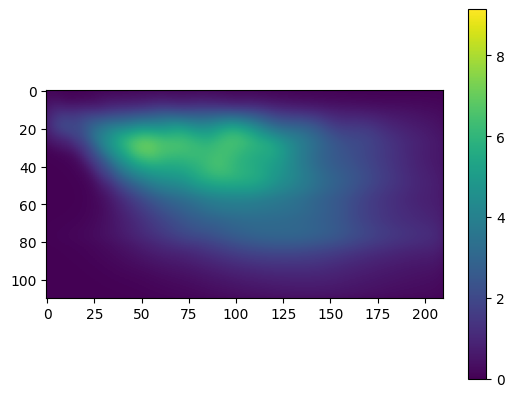

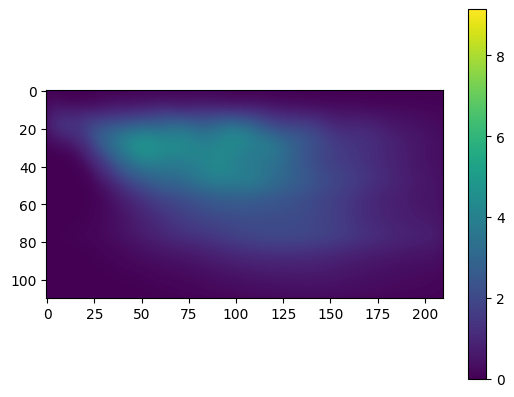

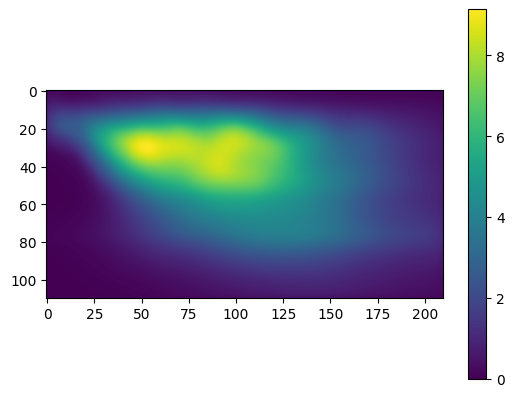

In [28]:
combined_data = np.array([mean,mean-std, mean+std])
#Get the min and max of all your data
_min, _max = np.amin(combined_data), np.amax(combined_data)

plt.imshow(mean, vmin=_min, vmax=_max)
plt.colorbar()
plt.show()
plt.imshow(mean - 1 * std, vmin=_min, vmax=_max)
plt.colorbar()
plt.show()
plt.imshow(mean + std, vmin=_min, vmax=_max)
plt.colorbar()